批处理ESD表格，主要把时间戳转化为时间轴

In [ ]:
import os
import pandas as pd

dirlist = os.listdir('../CollectedData/BINS/')
print(dirlist)
for i in dirlist:
    data = pd.read_csv('../CollectedData/BINS/'+i)
    time_df = data.iloc[:,0] # 获取时间戳的那一列
    bins_df = data.iloc[:,1:-1] # 获取bins的列
    data['max'] = bins_df.max(axis=1) # 找到bins中每一行的最大值，并且赋值给max列
    data['time'] = (time_df-time_df[0])/1000
    output = data[['time','max']]
    output.to_csv('../CollectedData/OutBINS/out_'+i, index=False)

超声波信号和音频信号相乘

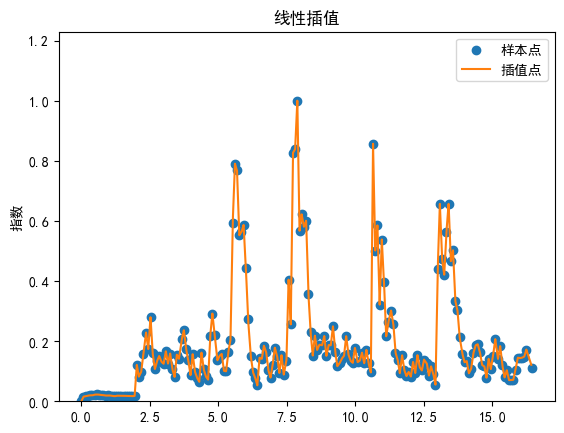

In [25]:
import utils.speechlib
from utils.soundBase import soundBase
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import matplotlib.pyplot as plt
import librosa
import scipy.interpolate as spi

sb = soundBase('../CollectedData/WAV/SingleWav1.wav') # 读取音频文件
audio_data , fs = sb.audioread()

esd_df = pd.read_csv('../CollectedData/OutBINS/out_TEST_BINS1.csv') # 读取ESD数据文件
esd_time = esd_df['time']
esd_data = esd_df['max']

# 音频幅值归一化
min_max_scaler1 = MinMaxScaler(feature_range=(-1,1),copy=True) # 定义归一化的范围为[-1,1]
audio_data_minmax = min_max_scaler1.fit_transform(audio_data.reshape(-1,1))
# sb.soundplot(audio_data_minmax,sr=fs)

# 超声波幅值归一化
min_max_scaler2 = MinMaxScaler(feature_range=(0,1),copy=True) # 定义归一化的范围为[0,1]
esd_data_minmax = min_max_scaler2.fit_transform(esd_data.values.reshape(-1,1))
# plt.plot(esd_time.values,esd_data_minmax)

# 音频下采样
audio_data_minmax_downsampled = librosa.resample(y=audio_data_minmax.reshape(1,-1),orig_sr = fs, target_sr= 16000) # 下采样至16Khz

# 超声波上采样
time = [i / 16000 for i in range(len(audio_data_minmax_downsampled.reshape(-1,1)))] # 音频的时间点
ipo1=spi.splrep(esd_time.values,esd_data_minmax,k=1) # 样本点导入，生成参数
upsample_esd =spi.splev(time,ipo1) # 根据观测点和样条参数，生成插值，观测点设置为音频的时间坐标

# plt.plot(esd_time.values,esd_data_minmax,'o',label='样本点')
# plt.plot(time,upsample_esd,label='插值点')
# plt.ylim(esd_data.values.min(),esd_data.values.max()+1)
# plt.ylabel('指数')
# plt.title('线性插值')
# plt.legend()